In [1]:
from matplotlib import pyplot as plt
import matplotlib
from datetime import datetime
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
from pprint import pprint
import math
pd.set_option('display.max_colwidth', -1)
fontdict={'fontsize':'xx-large'}

In [2]:
btc = pd.read_csv('./corr/btc.csv')

combined_raw = pd.read_csv('./combined.csv')
combined_drop_price = combined_raw.drop(combined_raw.loc[combined_raw['price']==0].index)

In [3]:
combined = combined_drop_price.merge(btc.drop(columns=['exchangeVolume(USD)','realizedCap(USD)','fees','paymentCount','medianTxValue(USD)','medianFee','blockSize','blockCount'],axis='columns'),left_on='date',right_on='date')

In [4]:
combined.tail(2)

,day,price,date,difficulty,recipients,num_tranc,btc_volume,usd_volume,txVolume(USD),adjustedTxVolume(USD),txCount,marketcap(USD),price(USD),generatedCoins,activeAddresses,averageDifficulty
1471,2018-09-07 00:00:00,6444.804167,2018-09-07,6.971177e+12,505243,230790.0,114506.972307,7.379750e+08,4.240383e+09,2.163449e+09,230638.0,1.126577e+11,6528.92,1900.0,689985.0,6.971177e+12
1472,2018-09-09 00:00:00,6286.425833,2018-09-09,7.019199e+12,358245,188912.0,73912.843387,4.646476e+08,2.682060e+09,1.367109e+09,188749.0,1.074099e+11,6223.38,2037.5,506835.0,7.019199e+12


In [5]:
def sardoff(x):
    return x

def metcalfe(x):
    return x.apply(lambda i: i**2)

def zipf(x):
    return x.apply(lambda x: x*math.log(x))

# def myLaw(x):
#     return x.apply(lambda x: x**3)

# def corr2price(y,columnPrice = 'price'):
#     x = combined[columnPrice]
#     return np.corrcoef(x,y)[0][1]

def corr2price(y,x):
    return np.corrcoef(x,y)[0][1]

def getLnData(data):
    return data.apply(lambda x: math.log(x))

def movingBackAvgSmoothed(series,day):
    res=[]
    for i in range(len(series)):
        index = i+1
        if index-day<0:
            smoothed = sum(series[:index])/float(index)
        else:
            smoothed = sum(series[index-day:index])/float(day)
        res.append(smoothed)
    return pd.Series(res)

def getAllCorr(df,column,priceColumn = 'price'):
    res = {}
    series = df[column]
    price_series = df[priceColumn]
    
    res['type'] = column
    res['S'] = corr2price(sardoff(series),price_series)
    res['M'] = corr2price(metcalfe(series),price_series)
    res['Z'] = corr2price(zipf(series),price_series)
    
    res['ln_S'] = corr2price(getLnData(sardoff(series)),getLnData(price_series))
    res['ln_M'] = corr2price(getLnData(metcalfe(series)),getLnData(price_series))
    res['ln_Z'] = corr2price(getLnData(zipf(series)),getLnData(price_series))
    return res

def getDataFrameFromDict(d):
    for key,val in d.items():
        if type(val) != list:
            d[key] = [val]
    df = pd.DataFrame(d)
    return df

def minMaxScale(data):
    maxVal = data.max() 
    minVal = data.min()
    valRange = maxVal-minVal
    return (data-minVal)/valRange


# blockinfo data

## addr corr

In [6]:
addressColumn = 'recipients'
combined['ln_price'] = combined['price'].apply(lambda x: math.log(x))
combined['ln_addr'] = combined[addressColumn].apply(lambda x: math.log(x))

combined['smooth_90_addr'] = movingBackAvgSmoothed(combined[addressColumn],45)
combined['smooth_30_addr'] = movingBackAvgSmoothed(combined[addressColumn],15)
combined['smooth_30_price'] = movingBackAvgSmoothed(combined['price'],15)
combined['smooth_90_price'] = movingBackAvgSmoothed(combined['price'],45)


d1 = getAllCorr(combined,addressColumn,'price')
d2 = getAllCorr(combined,'smooth_30_addr','smooth_30_price')
d3 = getAllCorr(combined,'smooth_90_addr','smooth_90_price')

l = [d1,d2,d3]

# columns_order = ['S','M','Z','mine','ln_S','ln_M','ln_Z','ln_mine']
columns_order = ['S','M','Z','ln_S','ln_M','ln_Z']

addr_corr = pd.concat([getDataFrameFromDict(d) for d in l]).set_index('type')[columns_order]

addr_corr

,S,M,Z,ln_S,ln_M,ln_Z
type,,,,,,
recipients,0.654007,0.719876,0.662463,0.945569,0.945569,0.943975
smooth_30_addr,0.661941,0.737942,0.670870,0.953304,0.953304,0.951995
smooth_90_addr,0.659597,0.731673,0.668027,0.957310,0.957310,0.956047


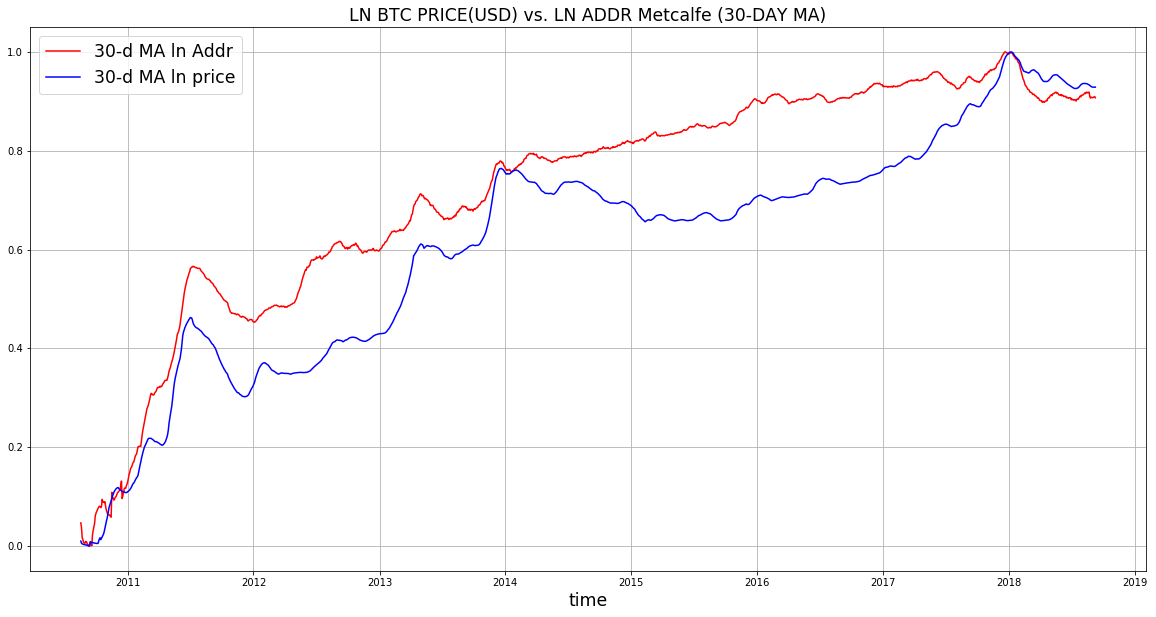

In [15]:
fig = plt.figure(figsize=(20,10))
time_formate = "%Y-%m-%d"
dates = combined['date'].apply(lambda x: datetime.strptime(x,time_formate))

line1 = plt.plot_date(dates,minMaxScale(getLnData(metcalfe(combined['smooth_30_addr']))),'r')
# line2 = plt.plot_date(dates,minMaxScale(getLnData(zipf(combined['smooth_30_addr']))),'g')
line3 = plt.plot_date(dates,minMaxScale(getLnData(combined['smooth_30_price'])),'b')
# plt.legend(('M_ln_smooth_30_addr','Z_ln_smooth_30_addr','ln_price'),loc='best',fontsize='xx-large')
plt.legend(('30-d MA ln Addr','30-d MA ln price'),loc='best',fontsize='xx-large')

plt.xlabel('time',fontdict={'fontsize':'xx-large'})
plt.title('LN BTC PRICE(USD) vs. LN ADDR Metcalfe (30-DAY MA)',fontdict={'fontsize':'xx-large'})
plt.grid(True)
plt.show()

## Ln without scale

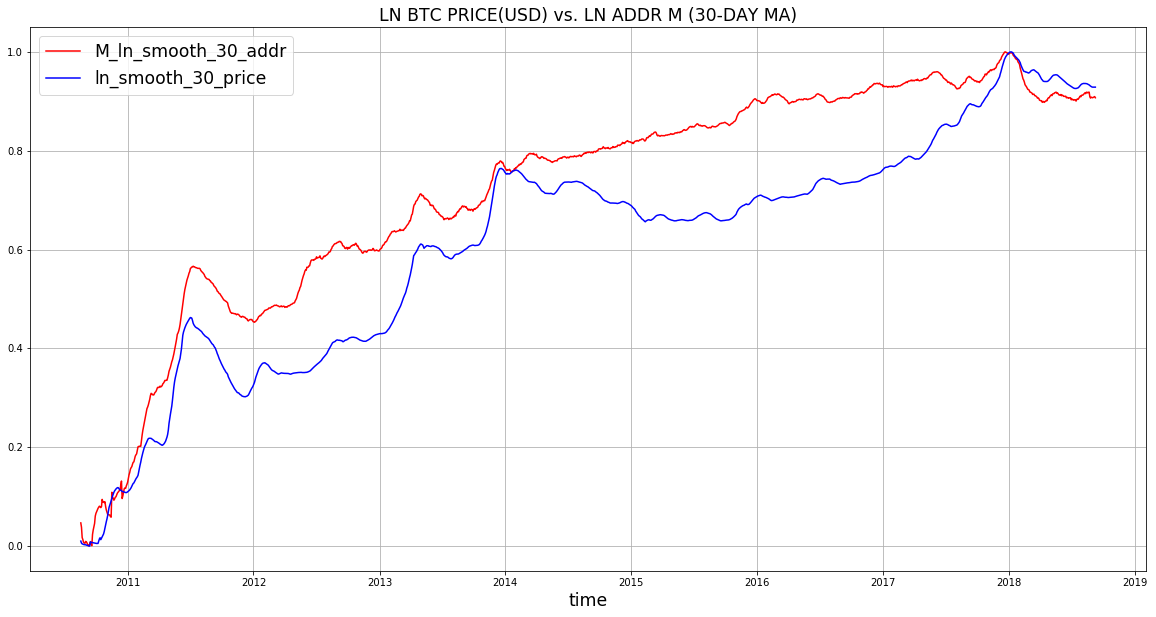

In [45]:
fig = plt.figure(figsize=(20,10))
time_formate = "%Y-%m-%d"
dates = combined['date'].apply(lambda x: datetime.strptime(x,time_formate))

m_data = getLnData(metcalfe(combined['smooth_30_addr']))
z_data = getLnData(zipf(combined['smooth_30_addr']))
price_data = getLnData(combined['smooth_30_price'])
line1 = plt.plot_date(dates,minMaxScale(m_data),'r')
# line2 = plt.plot_date(dates,z_data,'g')
line3 = plt.plot_date(dates,minMaxScale(price_data),'b')
plt.legend(('M_ln_smooth_30_addr','ln_smooth_30_price'),loc='best',fontsize='xx-large')

plt.xlabel('time',fontdict={'fontsize':'xx-large'})
plt.title('LN BTC PRICE(USD) vs. LN ADDR M (30-DAY MA)',fontdict={'fontsize':'xx-large'})
plt.grid(True)
plt.show()

## Linear scale  metcalfe fit

In [85]:
recent_price = pd.read_csv('./corr/market-price.csv')
recent_price['date'] = recent_price['date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
recent_price = recent_price.loc[index]

,date,price
0,2009-01-03,0.0
1,2009-01-05,0.0
2,2009-01-07,0.0
3,2009-01-09,0.0
4,2009-01-11,0.0


In [102]:
combined['date'] = combined['date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d"))

In [104]:
res = recent_price.merge(combined[['date','smooth_30_addr']],on='date',how='left')

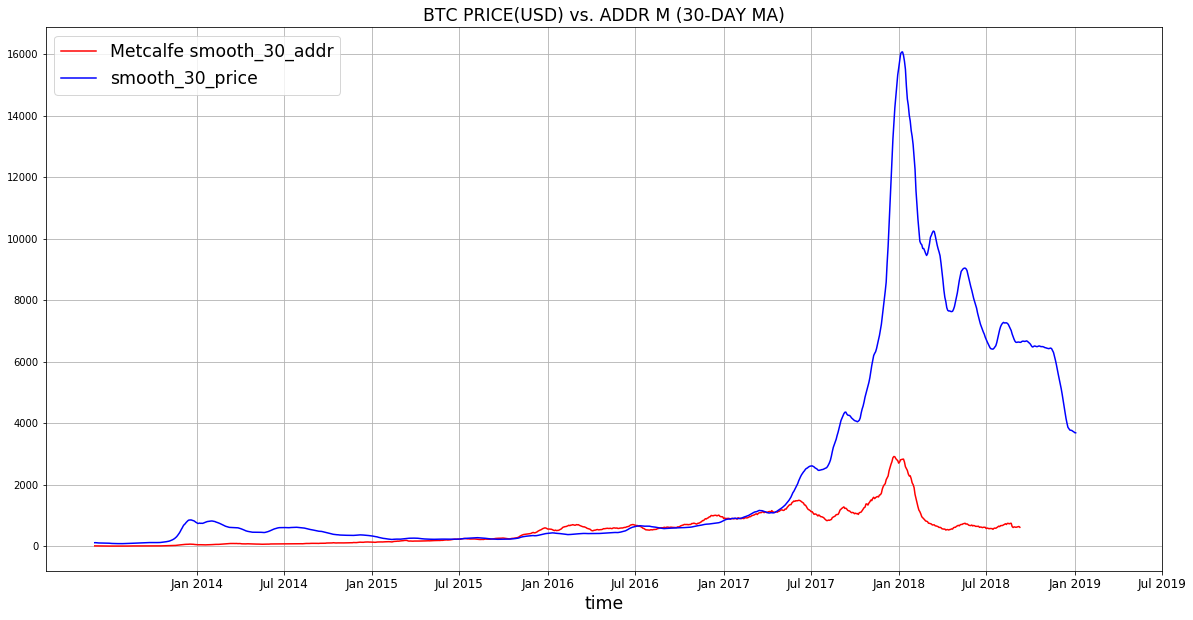

In [107]:
fig = plt.figure(figsize=(20,10))
# focus_index = dates.loc[dates>datetime(2013,6,1)].index
time_formate = "%Y-%m-%d"
dates = res['date']

line1 = plt.plot_date(dates,metcalfe(res['smooth_30_addr'])*4*10**(-9),'r')

# line2 = plt.plot_date(dates[focus_index],combined['smooth_30_price'][focus_index],'b')
line2 = plt.plot_date(dates,movingBackAvgSmoothed(res['price'],15),'b')

xticks = [dt.date(i,j,1) for i in range(2014,2020) for j in [1,7]]
stick_labels = [dt.date(i,j,1).strftime('%b %Y')  for i in range(2014,2020) for j in [1,7]]


plt.legend(('Metcalfe smooth_30_addr', 'smooth_30_price'),loc='best',fontsize='xx-large')
plt.xticks(xticks,stick_labels,fontsize='large')
plt.xlabel('time',fontdict={'fontsize':'xx-large'})
plt.title('BTC PRICE(USD) vs. ADDR M (30-DAY MA)',fontdict={'fontsize':'xx-large'})
plt.grid(True)
plt.show()

## Linear focus fit

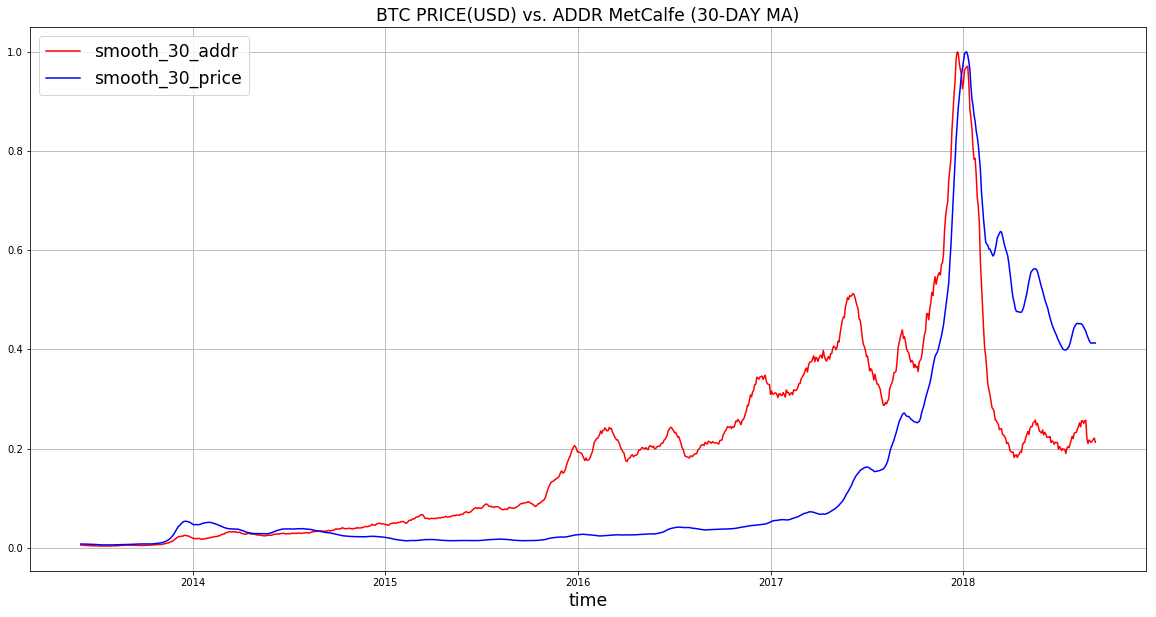

In [41]:
focus_index = dates.loc[dates>datetime(2013,6,1)].index

fig = plt.figure(figsize=(20,10))
time_formate = "%Y-%m-%d"
dates = combined['date'].apply(lambda x: datetime.strptime(x,time_formate))

# for activeAddress
# line1 = plt.plot_date(dates,metcalfe(combined['smooth_30_addr']*4*10**(-4.5)),'r')  
line1 = plt.plot_date(dates[focus_index],minMaxScale(metcalfe(combined['smooth_30_addr']))[focus_index],'r')

line2 = plt.plot_date(dates[focus_index],minMaxScale(combined['smooth_30_price'])[focus_index],'b')
plt.legend(('smooth_30_addr', 'smooth_30_price'),loc='best',fontsize='xx-large')

plt.xlabel('time',fontdict={'fontsize':'xx-large'})
plt.title('BTC PRICE(USD) vs. ADDR MetCalfe (30-DAY MA)',fontdict={'fontsize':'xx-large'})
plt.grid(True)
plt.show()

## PMR

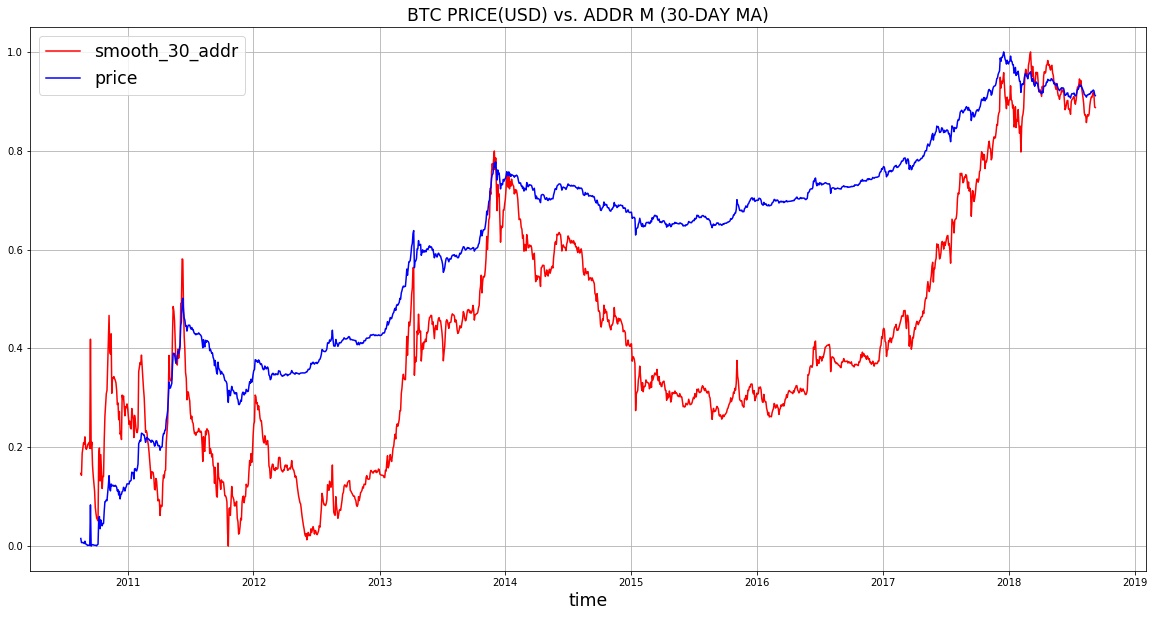

In [196]:
fig = plt.figure(figsize=(20,10))
time_formate = "%Y-%m-%d"
dates = combined['date'].apply(lambda x: datetime.strptime(x,time_formate))
PMR = minMaxScale(getLnData(combined['price']/ zipf(combined['smooth_30_addr'])))
line1 = plt.plot_date(dates,PMR,'r')

line2 = plt.plot_date(dates,minMaxScale(combined['ln_price']),'b')
plt.legend(('smooth_30_addr', 'price'),loc='best',fontsize='xx-large')

plt.xlabel('time',fontdict={'fontsize':'xx-large'})
plt.title('BTC PRICE(USD) vs. ADDR M (30-DAY MA)',fontdict={'fontsize':'xx-large'})
plt.grid(True)
plt.show()

## tranc corr

In [24]:
addressColumn = 'num_tranc'
combined['ln_price'] = combined['price'].apply(lambda x: math.log(x))
combined['ln_tranc'] = combined[addressColumn].apply(lambda x: math.log(x))

combined['smooth_90_tranc'] = movingBackAvgSmoothed(combined[addressColumn],45)
combined['smooth_30_tranc'] = movingBackAvgSmoothed(combined[addressColumn],15)

d1 = getAllCorr(combined,addressColumn,'price')
d2 = getAllCorr(combined,'smooth_30_tranc','smooth_30_price')
d3 = getAllCorr(combined,'smooth_90_tranc','smooth_90_price')

l = [d1,d2,d3]

columns_order = ['S','M','Z','ln_S','ln_M','ln_Z']
addr_corr = pd.concat([getDataFrameFromDict(d) for d in l]).set_index('type')[columns_order]
addr_corr

,S,M,Z,ln_S,ln_M,ln_Z
type,,,,,,
num_tranc,0.569154,0.585793,0.572671,0.925117,0.925117,0.924215
smooth_30_tranc,0.576542,0.602259,0.580688,0.932021,0.932021,0.931326
smooth_90_tranc,0.574668,0.592682,0.578293,0.938396,0.938396,0.937844


## difficulty corr

In [43]:
addressColumn = 'difficulty'
combined['ln_price'] = combined['price'].apply(lambda x: math.log(x))
combined['ln_diff'] = combined[addressColumn].apply(lambda x: math.log(x))

combined['smooth_90_diff'] = movingBackAvgSmoothed(combined[addressColumn],45)
combined['smooth_30_diff'] = movingBackAvgSmoothed(combined[addressColumn],15)

d1 = getAllCorr(combined,addressColumn,'price')
d2 = getAllCorr(combined,'smooth_30_diff','smooth_30_price')
d3 = getAllCorr(combined,'smooth_90_diff','smooth_90_price')

l = [d1,d2,d3]

columns_order = ['S','M','Z','ln_S','ln_M','ln_Z']
addr_corr = pd.concat([getDataFrameFromDict(d) for d in l]).set_index('type')[columns_order]
addr_corr

,S,M,Z,ln_S,ln_M,ln_Z
type,,,,,,
difficulty,0.755992,0.567926,0.748421,0.952609,0.952609,0.953611
smooth_30_diff,0.777599,0.591984,0.770272,0.953843,0.953843,0.954907
smooth_90_diff,0.827722,0.645968,0.820985,0.956043,0.956043,0.957226


## straight plot

In [8]:
straight_plot = pd.read_csv('./straight_plot.csv')


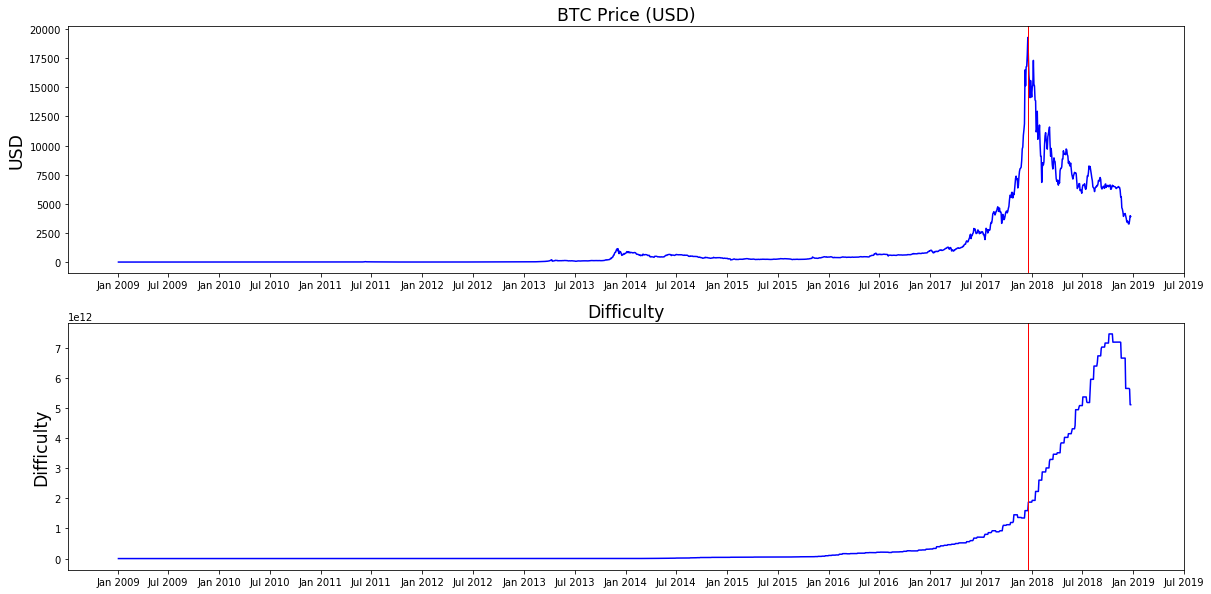

In [9]:
f = plt.figure(figsize=(20,10))
# columns = ['price','difficulty','activeAddresses','num_tranc']
# titles = ['BTC Price (USD)','Difficulty','Number Of Unique ActiveAddress','Confirmed Transactions Per Day']
# ylabels = ['USD','Difficulty','Addresses','Transactions']

columns = ['price','difficulty']
titles = ['BTC Price (USD)','Difficulty']
ylabels = ['USD','Difficulty']

time_formate = "%Y-%m-%d"
dates = straight_plot['date'].apply(lambda x: datetime.strptime(x,time_formate))
line_date = datetime(year=2017,month=12,day=17)

xticks = [dt.date(i,j,1) for i in range(2009,2020) for j in [1,7]]
stick_labels = [dt.date(i,j,1).strftime('%b %Y')  for i in range(2009,2020) for j in [1,7]]

for i,column in enumerate(columns):
    plt.subplot(len(columns),1,i+1)
    plt.plot_date(dates,straight_plot[column],'b-')
    plt.axvline(x=line_date,linewidth=1, color='r')
    plt.title(titles[i],fontdict=fontdict)
    plt.ylabel(ylabels[i],fontdict=fontdict)
    plt.xticks(ticks=xticks,labels=stick_labels)


## block miner

In [230]:
len(all_block_miner['miner_key'].unique())

83194

In [242]:
all_block_miner.head(2)

,day,miner_key,block_id
0,2016-11-09 00:00:00+00:00,1CK6KHY6MHgYvmRQ4PAafKYDrg1ejbH1cE,00000000000000000038a2fc6d0500aa8b11e962d98c9d00b8a702836479ac3e
1,2016-01-10 00:00:00+00:00,1Mpce11eUTuP9mxyDixdFbJzPrdNEJkgB4,00000000000000000a46fddcc39daeac97e5463ea9625b0bf6b97d9db9e1fd96


In [232]:
group_res = all_block_miner.groupby('day').block_id.nunique()

Text(0, 0.5, 'Blocks')

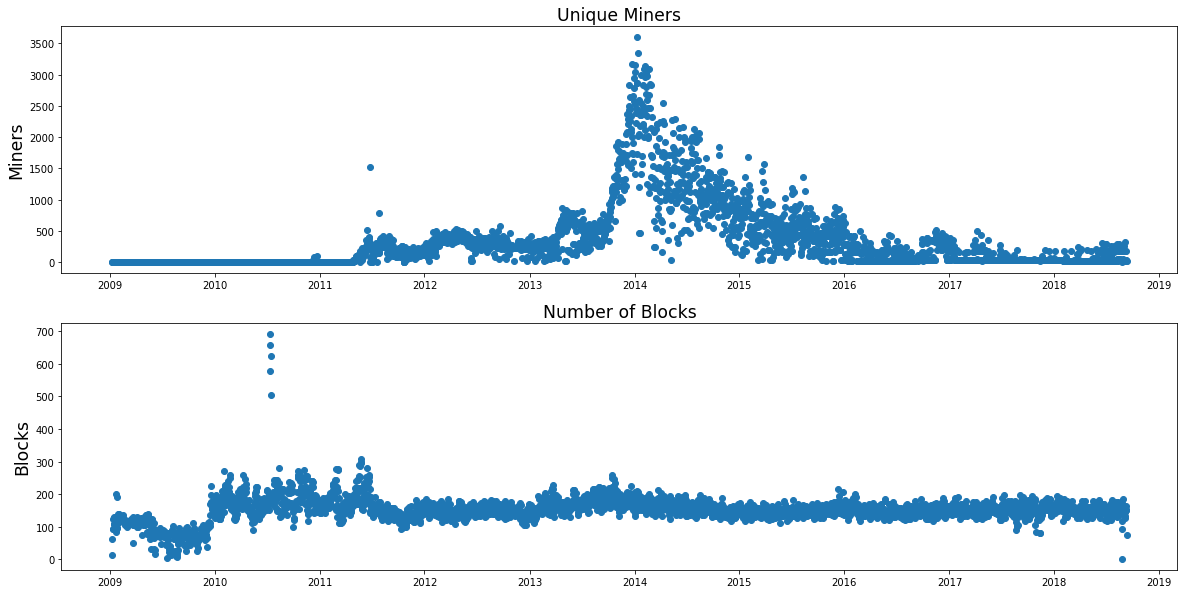

In [18]:
# all_block_miner = pd.read_csv('./all_block_minerkey.csv')
# time_format = '%Y-%m-%d'
# # all_block_miner['day'] = all_block_miner['day'].apply(lambda x: datetime.strptime(x,time_format))

# groupby = all_block_miner.groupby('day')

# group_res = groupby.block_id.nunique()
# day_num_block = pd.DataFrame({'day':group_res.index,'num_blocks':group_res.values})
# group_res = groupby.miner_key.nunique()
# day_num_miner = pd.DataFrame({'day':group_res.index,'num_miner':group_res.values})

f, axarr = plt.subplots(2,figsize=(20,10))
dates = day_num_miner['day'].apply(lambda x: datetime.strptime(x[:10],time_format))

axarr[0].plot_date(dates,day_num_miner['num_miner'])
axarr[0].set_title('Unique Miners',fontdict=fontdict)
axarr[0].set_ylabel('Miners',fontdict=fontdict)

axarr[1].plot_date(dates,day_num_block['num_blocks'])
axarr[1].set_title('Number of Blocks',fontdict=fontdict)
axarr[1].set_ylabel('Blocks',fontdict=fontdict)